In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt

In [22]:
def plot_result(result, start_from=1, period=17, insert_index=6, time_start=-7, file_name="result", title="Event Study Coefficients with Confidence Intervals"):
    summary_table = pd.DataFrame(result.summary.tables[1].data[start_from:start_from + period], columns=result.summary.tables[1].data[0])
    new_row = [0] * len(summary_table.columns)
    summary_table = pd.concat([summary_table.iloc[:insert_index], pd.DataFrame([new_row], columns=summary_table.columns), summary_table.iloc[insert_index:]]).reset_index(drop=True)

    summary_table["Time"] = np.array(list(range(time_start, period + time_start + 1)))
    summary_table = summary_table.apply(pd.to_numeric, errors='ignore')
    plt.figure(figsize=(10, 6))

    # Plot coefficients as points
    plt.plot(summary_table['Time'], summary_table["Parameter"], 'o-', label='Coefficients', color='b')

    # Plot confidence intervals as error bars
    plt.fill_between(summary_table['Time'], summary_table['Lower CI'], summary_table['Upper CI'], color='orange', alpha=0.3, label='Confidence Intervals')

    # Separate the data for regression before and after insert_index
    pre_insert_data = summary_table[summary_table['Time'] <= insert_index+time_start]
    post_insert_data = summary_table[summary_table['Time'] >= insert_index+time_start]

    # Perform regression before and after insert_index
    X_pre = sm.add_constant(pre_insert_data['Time'])
    X_post = sm.add_constant(post_insert_data['Time'])
    model_pre = sm.OLS(pre_insert_data['Parameter'], X_pre).fit()
    model_post = sm.OLS(post_insert_data['Parameter'], X_post).fit()

    # Plot regression lines
    plt.plot(pre_insert_data['Time'], model_pre.predict(X_pre), '--', label='Regression Line (Before Event)', color='green')
    plt.plot(post_insert_data['Time'], model_post.predict(X_post), '--', label='Regression Line (After Event)', color='purple')

    plt.xlabel('Time')
    plt.ylim(-1, 1)
    plt.ylabel("Parameter")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig("./plots/{}.png".format(file_name), dpi=300, bbox_inches="tight", transparent=False, facecolor="white")
    plt.show()


In [23]:
df=pd.read_csv("../../data/merged/len4_ndb_agg_all_DropNever.csv",encoding="shift-jis",index_col=0)

In [24]:
df["log_quantity"]=np.log(df["総計"])
df["log_revenue"]=np.log(df["revenue"])
df["year_trend"]=df["year"]-2014
df=df.set_index(["id","year"])
df=PanelData(df,convert_dummies=False)

                          PanelOLS Estimation Summary                           
Dep. Variable:           log_quantity   R-squared:                        0.0862
Estimator:                   PanelOLS   R-squared (Between):              0.0492
No. Observations:                 344   R-squared (Within):              -4726.0
Date:                Wed, Sep 06 2023   R-squared (Overall):             -39.412
Time:                        22:18:26   Log-likelihood                    124.36
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.1110
Entities:                          43   P-value                           0.3325
Avg Obs:                       8.0000   Distribution:                  F(23,271)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):          1.451e+08
                            

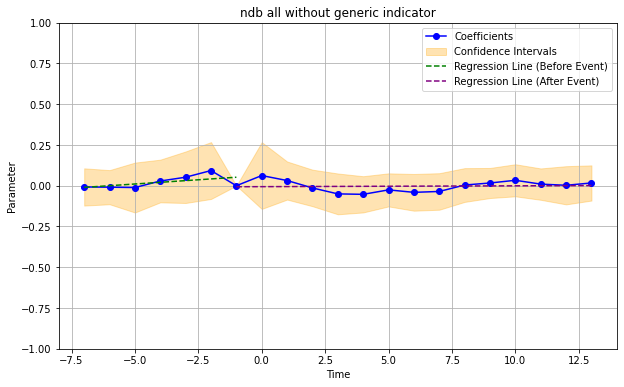

In [25]:
# all data
formula="log_quantity~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+TimeEffects+EntityEffects"

# till elasped_20
formula="log_quantity~ elasped_m5+elasped_m4+elasped_m3+elasped_m2+elasped_m1+elasped_0+elasped_1+elasped_2+elasped_3+elasped_4+elasped_5+elasped_6+elasped_7+elasped_8+elasped_9+elasped_10+elasped_11+elasped_12+elasped_13+elasped_14+elasped_15+TimeEffects+EntityEffects"


# add generic indicator
# formula+="+後発品区分"

# add generic per
# formula+="+generic_per"

formula+="+year_trend"
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"

mod_fe=PanelOLS.from_formula(formula, data=df,check_rank=False,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# print(res_fe.summary.tables[1])
# print(res_fe.summary.tables[0])
print(res_fe)
# plot_result(res_fe,file_name="ndb_all",title="ndb_all",start_from=1,period=15)
plot_result(res_fe,file_name="ndb_all_without_generic",title="ndb all without generic indicator",start_from=1,period=20)